# Implementação de um classificador com atributos mistos e com dados faltantes

### Aluno: Alisson da Silva Vieira

# Bibliotecas utilizadas

- Pandas: É uma biblioteca que fornece estruturas de dados rápidas, flexíveis e expressivas projetadas para tornar o trabalho com dados "relacionais" ou "rotulados" fácil e intuitivo. Tem como objetivo ser o bloco de construção fundamental de alto nível para fazer análises de dados.
- Seaborn: É uma biblioteca de visualização de dados Python baseada em matplotlib. Ele fornece uma interface de alto nível para desenhar gráficos estatísticos atraentes e informativos.
- Matplotlib: É uma biblioteca abrangente para a criação de visualizações estáticas, animadas e interativas em Python. Produz figuras com qualidade de publicação em uma variedade de formatos impressos e ambientes interativos em várias plataformas. Matplotlib pode ser usado em scripts Python, o shell Python e IPython, servidores de aplicativos da web e vários kits de ferramentas de interface gráfica do usuário.
- Scikit-learn: É uma biblioteca em Python para aprendizado de máquina desenvolvido com base no SciPy que fornece um conjunto de ferramentas de machine learning.

In [75]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import ttest_ind_from_stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

%matplotlib inline

# Abertura do arquivo

Além de abrir o arquivo, conseguimos observar os 5 primeiros valores da base de dados.

In [76]:
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Informações da base de dados

Conseguimos observar as tabelas, os tipos referente a elas e a quantidade de valores que ela possui.

Isso é importante para entedermos um pouco mais afundo dos nossos dados.

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Valores faltantes

Conseguimos ver acima, que há valores faltantes, mais especificamente nas colunas: 'Age', 'Cabin' e 'Embarked', porém a quantidade total desses valores faltantes pode ser vista abaixo:

In [78]:
f'Quantidade de valroes faltantes: {df.isnull().sum().sum()}'

'Quantidade de valroes faltantes: 866'

# Imputação

Para resolver esse problema, irei utilizar a técnica da imputação, nas colunas: 'Age' e 'Embarked' que possuem dados faltantes.

In [79]:
columns = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
atributos_numericos = ['Age']
atributos_categoricos = ['Embarked']

transformers = [
    ('imp_num', SimpleImputer(strategy='mean'), atributos_numericos),
    ('imp_cat', SimpleImputer(strategy='constant', fill_value='desconhecido'), atributos_categoricos)
]

ct_imp = ColumnTransformer(
    transformers, remainder='drop'
)

X_imp_vals = ct_imp.fit_transform(df)

X_imputed = pd.DataFrame(X_imp_vals, columns=[*atributos_numericos, *atributos_categoricos])

Após resolvido, além da minha tabela receber os dados completos agora também removo as colunas: 'PassengerId', 'Name', 'Ticket' e 'Cabin', pois são dados que nao nos ajudam em muita coisa.

In [80]:
df['Age'] = X_imputed['Age']
df['Embarked'] = X_imputed['Embarked']

df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    object 
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 55.8+ KB


# Conversão dos atributos categóricos para numéricos

Os valores categoricos da coluna 'Sex' foram transformados em atributos numéricos, então a equivalência: 'male' -> 0; 'female' -> 1.

Para realizar a conversão para valores numericos, utilizei o método 'to_numeric()' do pandas para as colunas 'Age' e 'Sex'.

Quanto aos valroes da coluna 'Embarked', criei 3 novas colunas com cada um dos possíveis valores: 'Southampton', 'Cherbourg' e 'Queenstown', agora sendo atributos binários.

In [81]:
df.loc[df['Sex'] == 'male', 'Sex'] = 1
df.loc[df['Sex'] == 'female', 'Sex'] = 2

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Sex'] = pd.to_numeric(df['Sex'], errors='coerce')

df.loc[df['Embarked'] == 'desconhecido', 'Embarked'] = 0
df.loc[df['Embarked'] == 'S', 'Embarked'] = 1
df.loc[df['Embarked'] == 'C', 'Embarked'] = 2
df.loc[df['Embarked'] == 'Q', 'Embarked'] = 3

Podemos observar os detalhes abaixo, e os 5 primeiros valores:

In [82]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB
None


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,1
1,1,1,2,38.0,1,0,71.2833,2
2,1,3,2,26.0,0,0,7.9250,1
3,1,1,2,35.0,1,0,53.1000,1
4,0,3,1,35.0,0,0,8.0500,1


# Distribuição de dados

Inicialmente, por questões de visualização, irei alterar o nome dos valores da coluna 'Survived', de 0 e 1 para 'Não sobrevivente' e 'Sobrevivente'.

E plotamos os histogramas para todos os atributos do conjunto de dados.

Inicialmente defino algumas funções para auxiliar na construção dos histogramas.

In [83]:
def change(df):
    df.loc[df['Survived'] == 1, 'Survived'] = 'Sobrevivente'
    df.loc[df['Survived'] == 0, 'Survived'] = 'Não sobrevivente'

def goBack(df):
    df.loc[df['Survived'] == 'Sobrevivente', 'Survived'] = 1
    df.loc[df['Survived'] == 'Não sobrevivente', 'Survived'] = 0
    df['Survived'] = pd.to_numeric(df['Survived'], errors='coerce')

def showHistogram(df, columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(8,4))

    for i, column in enumerate(columns):
        sns.histplot(data=df, bins=10, x=column, hue='Survived', multiple='dodge', shrink=0.8, ax=axes[i])

    plt.subplots_adjust(right=3.0, wspace=0.2)
    plt.show()

def showScatterplot(df, columns = ['Pclass', 'Sex', 'Age', 'SibSp',	'Parch', 'Fare', 'Embarked']):
    for idx, column in enumerate(columns):
        for col in columns[idx+1:]:
            sns.scatterplot(data=df, x=column, y=col, hue='Survived')
            plt.show()

def showBloxPlot(df):
    notShow = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
    for column in df.columns:
        if column not in notShow:
            sns.boxplot(data=df, y=column, x='Survived')
            plt.show()

# Histogramas

Ao plotar os histogramas, como são vistos abaixo, podemos perceber:
- Pclass (classe do bilhete):
    - Podemos perceber que, houve mais passageiros da classe 3 que da classe 2 e 1 que não sobreviveram.
- Sex:
    - Podemos perceber que há mais passageiros homens que não sobreviveram. Também percebemos que o mesmo não ocorre com as mulheres, pois o número de mulheres que sobreviveram é maior.
- Age:
    - Podemos perceber que há mais passageiros com idade entre 20 e 40 anos que não sobreviveram.
- SibSP:
    - Podemos perceber que há mais passageiros com o número de irmãos e conjugues igual a 0 que não sobreviveram.
- Parch:
    - Podemos perceber que há mais passageiros com o número de pais e filhos igual a 0 que não sobreviveram.
- Fare:
    - Podemos perceber que há mais passageiros que pagaram menos na passagem e não sobreviveram.
- Embarked:
    - Podemos perceber que há mais passageiros que partiram de Southampton que não sobreviveram.


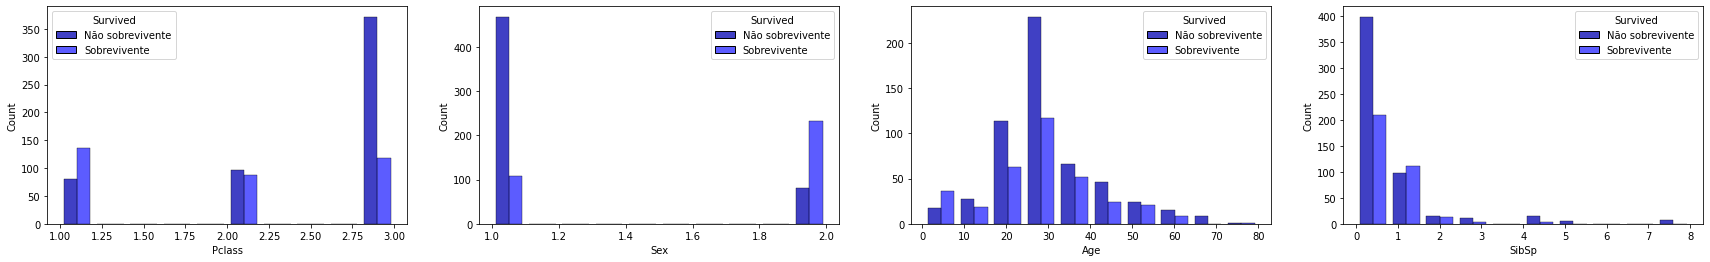

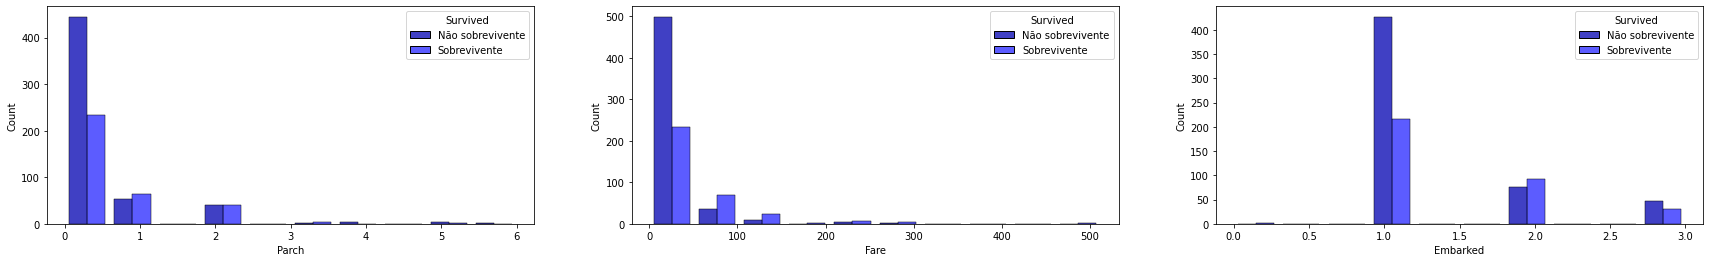

In [84]:
change(df)
showHistogram(df, ['Pclass', 'Sex', 'Age', 'SibSp'])
showHistogram(df, ['Parch', 'Fare', 'Embarked'])
goBack(df)

# Scatterplots

Para fins de se obter uma visualização mais detalhada da distribuição de alguns atributos em específico, irei plotar um bloxpot para os atributos: Age e Fare.

Podemos ver que não conseguimos perceber muita diferenciação quando a idade dos tripulantes, mas conseguimos ver uma leve diferença quanto a passagem paga.

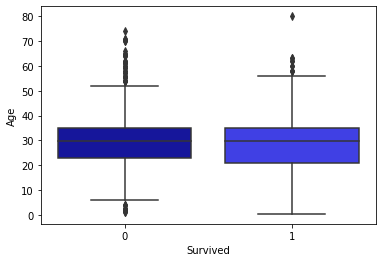

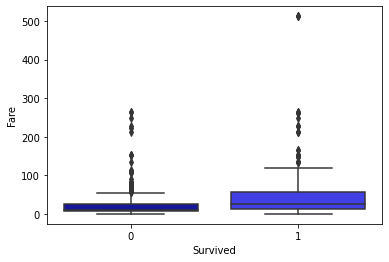

In [85]:
showBloxPlot(df)
['ring-type', 'ring-number', 'veil-color', 'veil-type']

# Normalização dos dados

Foi utilizado o método StandardScaler para normalizar os dados, para que os dados fossem mais facilmente compreendidos.

Ao final do processo, podemos ver os dados normalizados, como são vistos abaixo:

In [86]:
X = df.values
y = np.array(df['Survived'].values.tolist())

scaler = StandardScaler()
scaler.fit(X)

Xscaler = scaler.transform(X)

dataframe = pd.DataFrame(Xscaler, columns=df.columns)
dataframe

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,-0.789272,0.827377,-0.737695,-0.592481,0.432793,-0.473674,-0.502445,-0.562619
1,1.266990,-1.566107,1.355574,0.638789,0.432793,-0.473674,0.786845,1.003923
2,1.266990,0.827377,1.355574,-0.284663,-0.474545,-0.473674,-0.488854,-0.562619
3,1.266990,-1.566107,1.355574,0.407926,0.432793,-0.473674,0.420730,-0.562619
4,-0.789272,0.827377,-0.737695,0.407926,-0.474545,-0.473674,-0.486337,-0.562619
...,...,...,...,...,...,...,...,...
886,-0.789272,-0.369365,-0.737695,-0.207709,-0.474545,-0.473674,-0.386671,-0.562619
887,1.266990,-1.566107,1.355574,-0.823344,-0.474545,-0.473674,-0.044381,-0.562619
888,-0.789272,0.827377,1.355574,0.000000,0.432793,2.008933,-0.176263,-0.562619
889,1.266990,-1.566107,-0.737695,-0.284663,-0.474545,-0.473674,-0.044381,1.003923


# PCA

O PCA é um algoritmo de redução de dimensionalidade, e o mesmo é implementado logo abaixo.

Podemos observar a redução de dimensionalidade logo apos a execução.

In [87]:
pca = PCA(n_components=2)
pca.fit(Xscaler)

X_pca = pca.transform(Xscaler)
X_pca_df = pd.DataFrame(X_pca, columns=['PC_0', 'PC_1'])

print(f'Instâncias priginais: {str(Xscaler.shape)}\nInstâncias projetadas nos componentes principais: {str(X_pca_df.shape)}')

Instâncias priginais: (891, 8)
Instâncias projetadas nos componentes principais: (891, 2)


O gráfico logo abaixo, é a projeção do PCA sobre os 2 primeiros componentes principais a partir de todos os atributos originais do dataset.

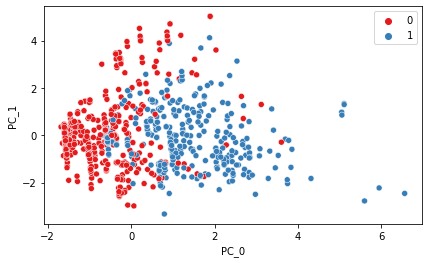

In [88]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC_0', y='PC_1', hue=y, palette='Set1')
plt.subplots_adjust(right=1.0)
plt.show()

# KNN & SVM

Agora, iremos utilizar ambos os classificadores KNN (K-Nearest Neighbours) e SVM (Support Vector Machine) para classificar os dados, e iremos utilizra a estratégia de validação cruzada em ambos os classificadores.

Abaixo, vemos as funções utilizadas para realizar a validação cruzada, e para mostrar os resultados.

In [89]:
'''
    ### Funções referente ao classificador KNN ####
'''

def selecionarMelhoresK(ks, X_treino, X_val, y_treino, y_val):

    # lista de acuracias
    acuracias_val = []

    # para cada um dos k's
    for k in ks:

        # crirar o classificador
        knn = KNeighborsClassifier(n_neighbors=k)

        # treinar o classificador
        knn.fit(X_treino, y_treino)

        # predizer
        pred = knn.predict(X_val)

        # calcular a acuracia
        acuracias_val.append(accuracy_score(y_val, pred))
    
    # melhor acuracia
    melhor_val = max(acuracias_val)

    # melhor k
    melhor_k = ks[np.argmax(acuracias_val)]        
    
    # criar o classificador com o melhor k
    knn = KNeighborsClassifier(n_neighbors=melhor_k)

    # treinar o classificador
    knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    # retorna o classificador, o melhor k e a melhor acuracia
    return knn, melhor_k, melhor_val

def validacaoCruzadaKnn(X, y, kVias = 10):

    print('Iniciando a validação cruzada com o classificado KNN...')

    # acuracias
    acuracias = []

    # usar o protocolo de validação cruzada estratificada
    skf = StratifiedKFold(n_splits=kVias, shuffle=True, random_state=1)

    pgb = tqdm(total=kVias, desc="Fold's avaliados")

    for idx_treino, idx_teste in skf.split(X, y):

        # extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
        X_treino = X[idx_treino]
        y_treino = y[idx_treino]
        
        # extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
        X_teste = X[idx_teste]
        y_teste = y[idx_teste]

        # separar as instâncias de treinamento entre treinamento e validação para a otimização do hiperparâmetro k
        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, shuffle=True, random_state=1)

        params = {'n_neighbors' : range(1,30,2)}

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        knn = GridSearchCV(KNeighborsClassifier(), params, cv=StratifiedKFold(n_splits=kVias))
        knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])

        pred = knn.predict(X_teste)

        # calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
        acuracias.append(accuracy_score(y_teste, pred))

        print('Predição:\n', classification_report(y_teste, pred), '\n\n')
        
        pgb.update(1)
        
    pgb.close()
    
    return acuracias

'''
    ### Funções referente ao classificador SVM ####
'''

def treinar_svm(C, gamma, X_treino, X_val, y_treino, y_val):
    
    # criar a instancia
    svm = SVC(C=C, gamma=gamma)

    # treinar a instancia
    svm.fit(X_treino, y_treino)

    # predizer o conjunto de validação
    pred = svm.predict(X_val)

    # retornar a acurácia
    return accuracy_score(y_val, pred)

def selecionarMelhoresSvm(Cs, gammas, X_treino : np.ndarray, X_val : np.ndarray, y_treino : np.ndarray, y_val : np.ndarray, n_jobs=4):
    
    # gera todas as combinações de parametros C e gamma, de acordo com as listas de valores recebidas por parametro.
    combinacoes_parametros = list(itertools.product(Cs, gammas))
    
    # Treinar modelos com todas as combinações de C e gamma
    acuracias_val = Parallel(n_jobs=n_jobs)(delayed(treinar_svm)(c, g, X_treino, X_val, y_treino, y_val) for c, g in combinacoes_parametros)       
    
    melhor_val = max(acuracias_val)

    # Encontrar a combinação que levou ao melhor resultado no conjunto de validação
    melhor_comb = combinacoes_parametros[np.argmax(acuracias_val)]   
    melhor_c = melhor_comb[0]
    melhor_gamma = melhor_comb[1]
    
    # Treinar uma SVM com todos os dados de treino e validação usando a melhor combinação de C e gamma.
    svm = SVC(C=melhor_c, gamma=melhor_gamma)
    svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])

    return svm, melhor_comb, melhor_val

def validacaoCruzadaSvm(X, y, cv_splits, Cs=[1], gammas=['scale']):

    print('Iniciando a validação cruzada com o classificador SVM...')

    parameters = [{
        "gamma": gammas,
        "C": Cs
    }]

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    acuracias = []
    
    pgb = tqdm(total=cv_splits, desc="Fold's avaliados")
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        svm = GridSearchCV(SVC(), parameters, cv=StratifiedKFold(n_splits=10))
        svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        
        pred = svm.predict(X_teste)

        acuracias.append(accuracy_score(y_teste, pred))

        print('Predição:\n', classification_report(y_teste, pred), '\n\n')
        
        pgb.update(1)
        
    pgb.close()
    
    return acuracias

'''
    ### Funções auxiliares ####
'''

def showResult(acc, legend):
    print('Resultado ', legend, '\n    >> Acc mínima: ', round(min(acc), 3), '%\n    >> Acc máxima: ', round(max(acc), 3), '%')
    print('    >> Média: ', round(np.mean(acc), 3), '\n    >> Desvio padrão: ', round(np.std(acc), 3), '\n')

    return np.mean(acc), np.std(acc)

def hipoteseNula(media1, std1, values1, media2, std2, values2, alpha=0.05):
    pvalor = ttest_ind_from_stats(media1, std1, len(values1), media2, std2, len(values2))[1]
    
    return pvalor <= alpha

# Aqui conseguimos ver a execução da validação cruzada, a saida mostra a predição para cada classe, e a acurácia do classificador, tanto para o KNN quanto para o SVM.

In [90]:
accKnn = validacaoCruzadaKnn(X, y)
accSvm = validacaoCruzadaSvm(X, y, 10, Cs=[1, 10, 100, 1000], gammas=['scale', 'auto', 2e-2, 2e-3, 2e-4])

Iniciando a validação cruzada com o classificado KNN...


Fold's avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Predição:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        35

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90
 


Predição:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        34

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89
 


Predição:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        34

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00  

Fold's avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Predição:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        35

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90
 


Predição:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        34

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89
 


Predição:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        34

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00  

# Aqui vemos os resultados sendo mostrados para cada classificador, e a verificação da hipótese nula ao final.

In [91]:
mediaKnn, stdKnn = showResult(accKnn, 'knn:')
mediaSvm, stdSvm = showResult(accSvm, 'svm:')

hpnula = hipoteseNula(mediaKnn, stdKnn, accKnn, mediaSvm, stdSvm, accSvm)

if hpnula:
    if mediaKnn > mediaSvm:
        classif = ' knn '
    else:
        classif = ' svm '

    text = 'verdadeira, podemos dizer que o' + classif + 'obteve um resultado melhor.'
else:
    text = 'falsa, não conseguimos afirmar que os dois resultados são estatisticamente diferentes.'

print('Hipotese nula:', text)

Resultado  knn: 
    >> Acc mínima:  0.966 %
    >> Acc máxima:  1.0 %
    >> Média:  0.997 
    >> Desvio padrão:  0.01 

Resultado  svm: 
    >> Acc mínima:  0.989 %
    >> Acc máxima:  1.0 %
    >> Média:  0.999 
    >> Desvio padrão:  0.003 

Hipotese nula: falsa, não conseguimos afirmar que os dois resultados são estatisticamente diferentes.
